In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
import torchvision.transforms as transforms
from torchvision import models, transforms, datasets
from tqdm import tqdm
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import copy
import numpy as np

In [8]:
import copy
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

# transform = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])


# Transformations
# RC = transforms.RandomCrop(32, padding=4)
# RHF = transforms.RandomHorizontalFlip()
# RVF = transforms.RandomVerticalFlip()
# NRM = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# TT = transforms.ToTensor()
# TPIL = transforms.ToPILImage()

# GB = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
# CJ = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
# RA = transforms.RandomAutocontrast()

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


transform_test = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

frog_train_dataset = copy.deepcopy(train_dataset)

# Train data
targets = np.array(train_dataset.targets)
train_dataset.data = train_dataset.data[targets != 6]
train_dataset.targets = torch.tensor(targets[targets != 6]).tolist()
train_dataset.targets = [target - 1 if target > 6 else target for target in train_dataset.targets]

# Frog train
targets = np.array(frog_train_dataset.targets)
frog_train_dataset.data = frog_train_dataset.data[targets == 6]
frog_train_dataset.targets = torch.tensor(targets[targets == 6]).tolist()

frog_test_dataset = copy.deepcopy(test_dataset)

# Test data
targets = np.array(test_dataset.targets)
test_dataset.data = test_dataset.data[targets != 6]
test_dataset.targets = torch.tensor(targets[targets != 6]).tolist()
test_dataset.targets = [target - 1 if target > 6 else target for target in test_dataset.targets]

# Frog test
targets = np.array(frog_test_dataset.targets)
frog_test_dataset.data = frog_test_dataset.data[targets == 6]
frog_test_dataset.targets = torch.tensor(targets[targets == 6]).tolist()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
frog_train_dataloader = torch.utils.data.DataLoader(frog_train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)
frog_test_dataloader = torch.utils.data.DataLoader(frog_test_dataset, batch_size=128, shuffle=True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


# Modeling Part (Frog)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

#for param in model.parameters():
#    param.requires_grad = False

model.fc = nn.Linear(512, 9)

model = model.to(device)
criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 200
history={"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[],"epochs":[]}
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    model.train()
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_predictions
    history["train_loss"].append(epoch_loss)
    history["train_acc"].append(epoch_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
      for inputs, labels in test_dataloader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)
          total_predictions += labels.size(0)
          correct_predictions += (predicted == labels).sum().item()

          running_loss += loss.item()

    epoch_loss = running_loss / len(test_dataloader)
    epoch_accuracy = correct_predictions / total_predictions
    history["val_loss"].append(epoch_loss)
    history["val_acc"].append(epoch_accuracy)
    history["epochs"].append(epoch)
    #print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

print("Training finished!")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/200], Loss: 1.2726, Accuracy: 0.5382
Epoch [2/200], Loss: 0.8675, Accuracy: 0.6899
Epoch [3/200], Loss: 0.7478, Accuracy: 0.7346
Epoch [4/200], Loss: 0.6788, Accuracy: 0.7594
Epoch [5/200], Loss: 0.6255, Accuracy: 0.7782
Epoch [6/200], Loss: 0.5806, Accuracy: 0.7940
Epoch [7/200], Loss: 0.5476, Accuracy: 0.8052
Epoch [8/200], Loss: 0.5170, Accuracy: 0.8158
Epoch [9/200], Loss: 0.4942, Accuracy: 0.8237
Epoch [10/200], Loss: 0.4763, Accuracy: 0.8313
Epoch [11/200], Loss: 0.4502, Accuracy: 0.8379
Epoch [12/200], Loss: 0.4360, Accuracy: 0.8450
Epoch [13/200], Loss: 0.4169, Accuracy: 0.8492
Epoch [14/200], Loss: 0.3959, Accuracy: 0.8592
Epoch [15/200], Loss: 0.3818, Accuracy: 0.8617
Epoch [16/200], Loss: 0.3681, Accuracy: 0.8662
Epoch [17/200], Loss: 0.3562, Accuracy: 0.8706
Epoch [18/200], Loss: 0.3444, Accuracy: 0.8761
Epoch [19/200], Loss: 0.3293, Accuracy: 0.8806
Epoch [20/200], Loss: 0.3193, Accuracy: 0.8827
Epoch [21/200], Loss: 0.3056, Accuracy: 0.8906
Epoch [22/200], Loss: 

# Plotting Accuracy and Loss

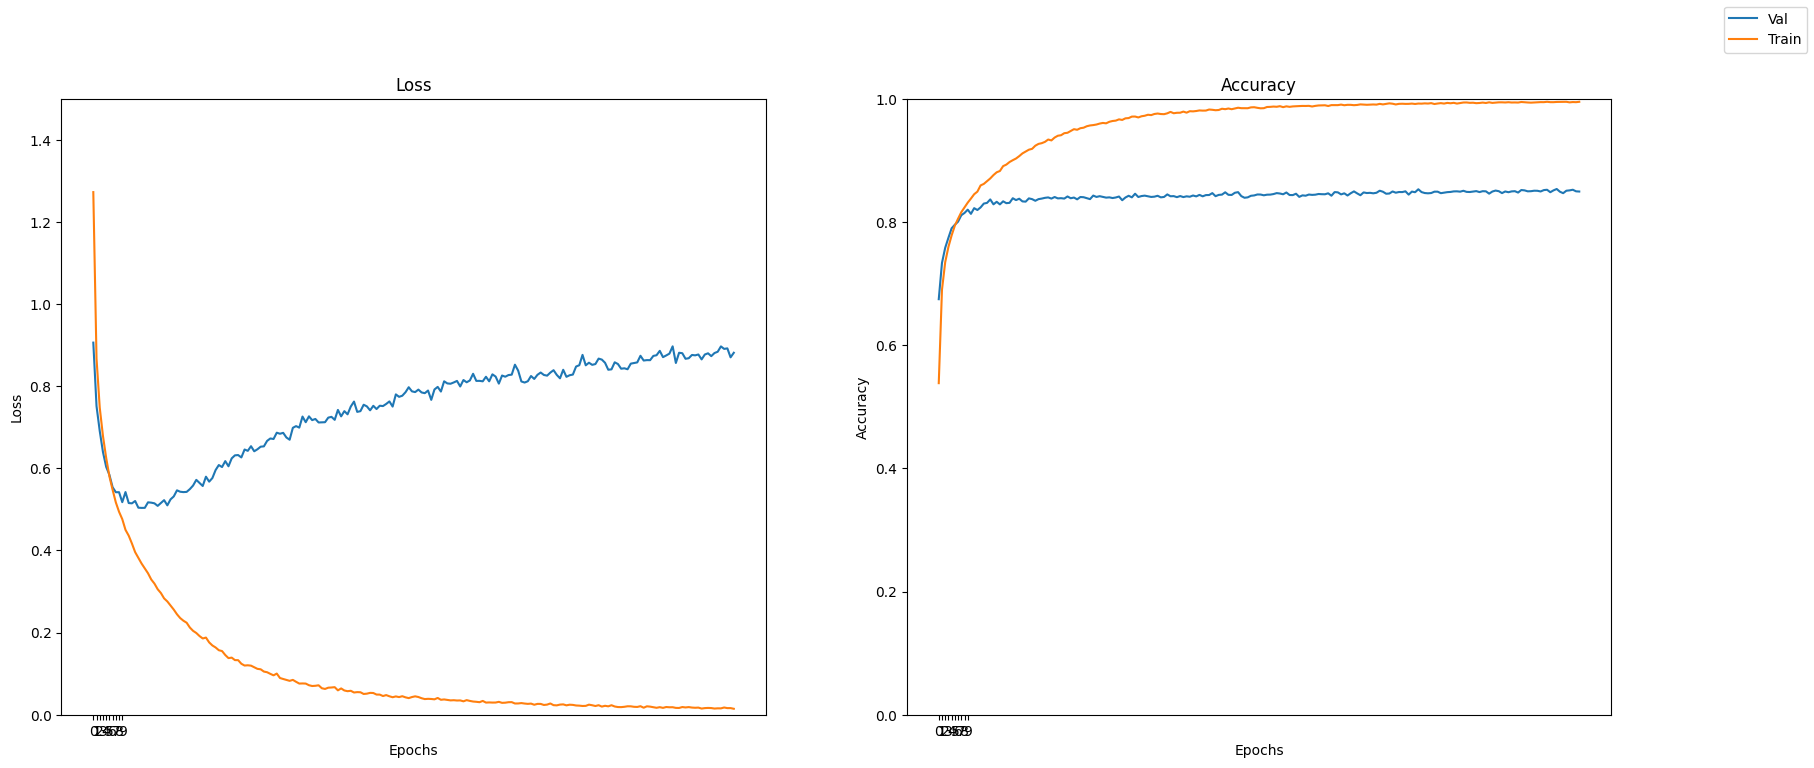

In [10]:
figure, axis = plt.subplots(1, 2,figsize=(20,8))
axis[0].plot(history['epochs'],history['val_loss'])
axis[0].plot(history['epochs'],history['train_loss'])
axis[0].set_xticks(range(10))
axis[0].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracy")
axis[0].set_ylim([0, 1.5])
axis[0].set_title("Loss")
axis[1].plot(history['epochs'],history['val_acc'])
axis[1].plot(history['epochs'],history['train_acc'])
axis[1].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[1].set_title("Accuracy")
axis[1].set_ylim([0, 1])
axis[1].set_xticks(range(10))
figure.legend(["Val", "Train"], loc='upper right')

In [51]:
tresh=0.694
total_count=0
ratio=0
model.eval()
total_count=0
with torch.no_grad():
  for x ,y in test_dataloader:
    x = x.to(device)
    this= model(x)
    probabilities = nn.Softmax(dim=1)(this)
    max_prob, predicted = torch.max(probabilities, dim=1)
    #max_prob, predicted = torch.max(this, dim=1)
    count = sum(1 for num in max_prob if num > tresh)
    total_count=count+total_count
ratio=total_count/len(test_dataloader.dataset)

In [52]:
print(f'ratio of inliers predicted by the model: {ratio}')

ratio of inliers predicted by the model: 0.95


In [53]:
tresh=0.694
total_count=0
ratio=0
model.eval()
total_count=0
with torch.no_grad():
  for x ,y in frog_test_dataloader:
    x = x.to(device)
    this= model(x)
    probabilities = nn.Softmax(dim=1)(this)
    max_prob, predicted = torch.max(probabilities, dim=1)
    #max_prob, predicted = torch.max(this, dim=1)
    count = sum(1 for num in max_prob if num > tresh)
    total_count=count+total_count
ratio=total_count/len(frog_test_dataloader.dataset)
print(f'ratio of inliers predicted by the model for the frog class: {ratio}')

ratio of inliers predicted by the model for the frog class: 0.855


# Load data (Cat as outlier)

In [56]:
import copy
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

# transform = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


transform_test = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

cat_train_dataset = copy.deepcopy(train_dataset)

# Train data
targets = np.array(train_dataset.targets)
train_dataset.data = train_dataset.data[targets != 3]
train_dataset.targets = torch.tensor(targets[targets != 3]).tolist()
train_dataset.targets = [target - 1 if target > 3 else target for target in train_dataset.targets]

# Cat train
targets = np.array(cat_train_dataset.targets)
cat_train_dataset.data = cat_train_dataset.data[targets == 3]
cat_train_dataset.targets = torch.tensor(targets[targets == 3]).tolist()

cat_test_dataset = copy.deepcopy(test_dataset)

# Test data
targets = np.array(test_dataset.targets)
test_dataset.data = test_dataset.data[targets != 3]
test_dataset.targets = torch.tensor(targets[targets != 3]).tolist()
test_dataset.targets = [target - 1 if target > 3 else target for target in test_dataset.targets]

# Cat test
targets = np.array(cat_test_dataset.targets)
cat_test_dataset.data = cat_test_dataset.data[targets == 3]
cat_test_dataset.targets = torch.tensor(targets[targets == 3]).tolist()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
cat_train_dataloader = torch.utils.data.DataLoader(cat_train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)
cat_test_dataloader = torch.utils.data.DataLoader(cat_test_dataset, batch_size=128, shuffle=True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


# Modeling Part (Cat)

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

#for param in model.parameters():
#    param.requires_grad = False

model.fc = nn.Linear(512, 9)

model = model.to(device)
criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 200
history={"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[],"epochs":[]}
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    model.train()
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_predictions
    history["train_loss"].append(epoch_loss)
    history["train_acc"].append(epoch_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
      for inputs, labels in test_dataloader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)
          total_predictions += labels.size(0)
          correct_predictions += (predicted == labels).sum().item()

          running_loss += loss.item()

    epoch_loss = running_loss / len(test_dataloader)
    epoch_accuracy = correct_predictions / total_predictions
    history["val_loss"].append(epoch_loss)
    history["val_acc"].append(epoch_accuracy)
    history["epochs"].append(epoch)
    #print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

print("Training finished!")


Epoch [1/200], Loss: 1.2124, Accuracy: 0.5691
Epoch [2/200], Loss: 0.7906, Accuracy: 0.7237
Epoch [3/200], Loss: 0.6724, Accuracy: 0.7664
Epoch [4/200], Loss: 0.5958, Accuracy: 0.7931
Epoch [5/200], Loss: 0.5437, Accuracy: 0.8083
Epoch [6/200], Loss: 0.4993, Accuracy: 0.8280
Epoch [7/200], Loss: 0.4730, Accuracy: 0.8340
Epoch [8/200], Loss: 0.4449, Accuracy: 0.8439
Epoch [9/200], Loss: 0.4177, Accuracy: 0.8544
Epoch [10/200], Loss: 0.4000, Accuracy: 0.8602
Epoch [11/200], Loss: 0.3778, Accuracy: 0.8661
Epoch [12/200], Loss: 0.3630, Accuracy: 0.8737
Epoch [13/200], Loss: 0.3422, Accuracy: 0.8791
Epoch [14/200], Loss: 0.3303, Accuracy: 0.8826
Epoch [15/200], Loss: 0.3173, Accuracy: 0.8908
Epoch [16/200], Loss: 0.2990, Accuracy: 0.8944
Epoch [17/200], Loss: 0.2891, Accuracy: 0.8979
Epoch [18/200], Loss: 0.2801, Accuracy: 0.9023
Epoch [19/200], Loss: 0.2703, Accuracy: 0.9038
Epoch [20/200], Loss: 0.2600, Accuracy: 0.9085
Epoch [21/200], Loss: 0.2430, Accuracy: 0.9144
Epoch [22/200], Loss: 

# Plotting Accuracy and Loss

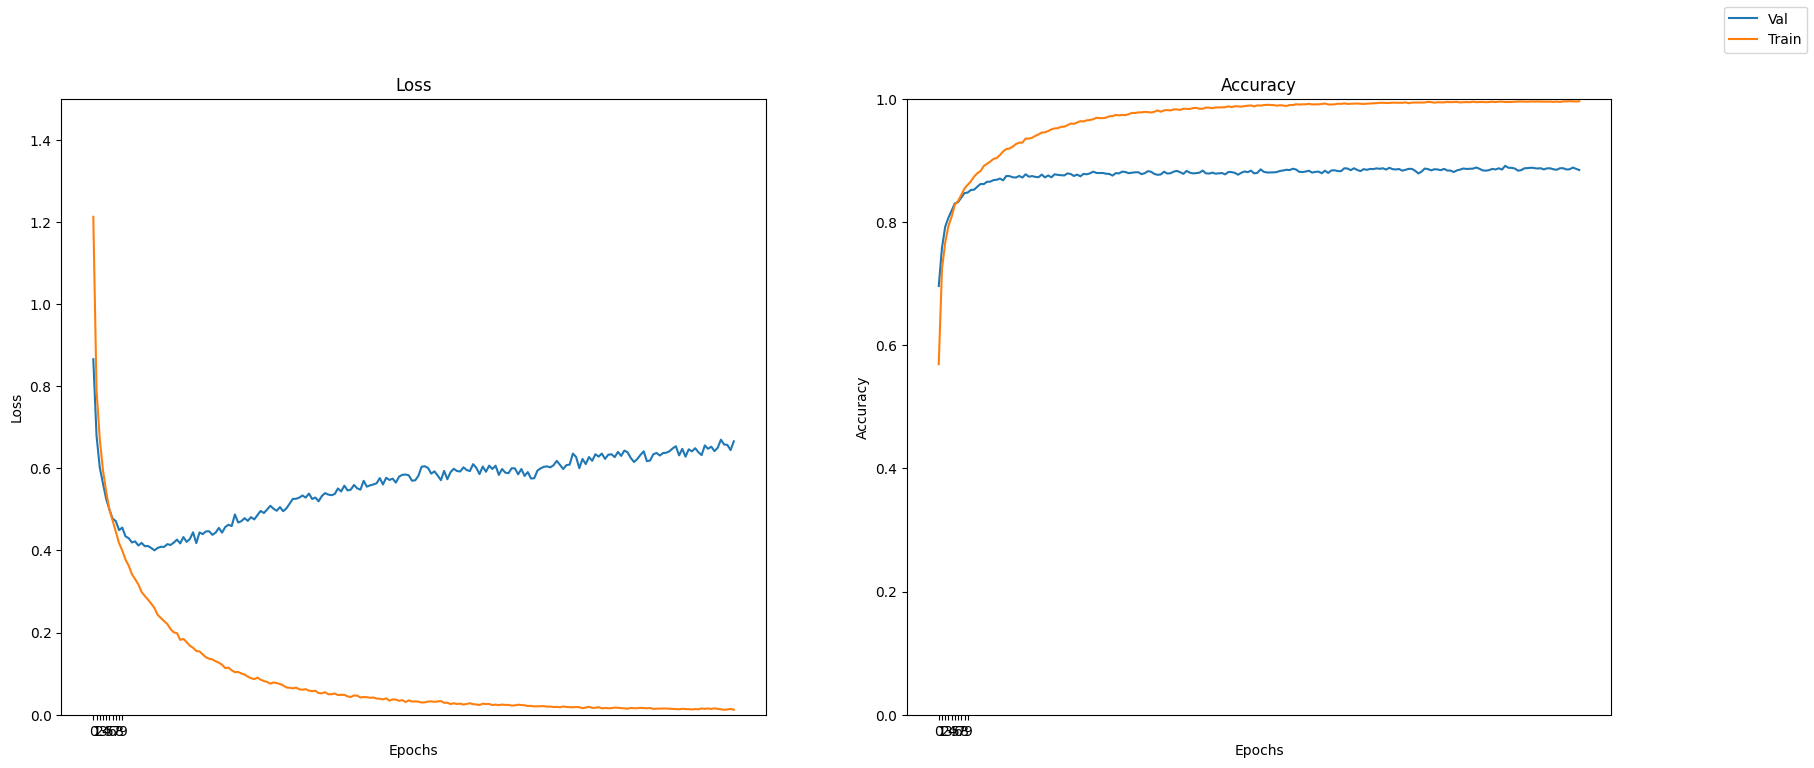

In [59]:
figure, axis = plt.subplots(1, 2,figsize=(20,8))
axis[0].plot(history['epochs'],history['val_loss'])
axis[0].plot(history['epochs'],history['train_loss'])
axis[0].set_xticks(range(10))
axis[0].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracy")
axis[0].set_ylim([0, 1.5])
axis[0].set_title("Loss")
axis[1].plot(history['epochs'],history['val_acc'])
axis[1].plot(history['epochs'],history['train_acc'])
axis[1].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[1].set_title("Accuracy")
axis[1].set_ylim([0, 1])
axis[1].set_xticks(range(10))
figure.legend(["Val", "Train"], loc='upper right')

In [79]:
tresh= 0.754
total_count=0
ratio=0
model.eval()
total_count=0
with torch.no_grad():
  for x ,y in test_dataloader:
    x = x.to(device)
    this= model(x)
    probabilities = nn.Softmax(dim=1)(this)
    max_prob, predicted = torch.max(probabilities, dim=1)
    #max_prob, predicted = torch.max(this, dim=1)
    count = sum(1 for num in max_prob if num > tresh)
    total_count=count+total_count
ratio=total_count/len(test_dataloader.dataset)
print(f'ratio of inliers predicted by the model: {ratio}')

ratio of inliers predicted by the model: 0.9503333333333334


In [80]:
tresh= 0.754
total_count=0
ratio=0
model.eval()
total_count=0
with torch.no_grad():
  for x ,y in cat_test_dataloader:
    x = x.to(device)
    this= model(x)
    probabilities = nn.Softmax(dim=1)(this)
    max_prob, predicted = torch.max(probabilities, dim=1)
    #max_prob, predicted = torch.max(this, dim=1)
    count = sum(1 for num in max_prob if num > tresh)
    total_count=count+total_count
ratio=total_count/len(cat_test_dataloader.dataset)
print(f'ratio of inliers predicted by the model for the cat class: {ratio}')

ratio of inliers predicted by the model for the cat class: 0.826
